In [160]:
from autograd import elementwise_grad as egrad
from autograd import jacobian
import autograd.numpy as np
import pandas as pd
import scipy.stats as sps
import os.path
import os
from sklearn.datasets import make_classification

from scipy.optimize import minimize
import seaborn as sns

from PyPDF2 import PdfFileMerger

sns.set(font_scale=2)
sns.set_style('whitegrid')

In [92]:
# Experiment params
batch_sizes_list = [1, 2, 4, 8]
lambda_list = [0.1, 0.001, 0.0001]

data_file = '../data/saved_data2.0.csv'
paper_dir = '../paper/'
paper_file = 'Melnikov2022StochasticNewtonWithArbitrarySampling.tex'

In [93]:
# decorator that saves experiments results into the file
# func has to return dataframe with the same columns

def saver(filename):
    def wraps(func):
        def wrapper(*args, **argv):
            res = func(*args, **argv)
            if os.path.isfile(filename):
                df = pd.read_csv(filename)
                version = df['version'].max() + 1
                res['version'] = np.ones(len(res)) * version
                df = df.append(res)
#                 display(df)
                df.to_csv(filename,index=False)
            else:
                res['version'] = np.zeros(len(res), dtype=np.int32)
                res.to_csv(filename, index=False)
            return res
        
        return wrapper
    return wraps


def typer(type_name):
    def wraps(func):
        def wrapper(*args, **argv): 
            return func(*args, **argv)
        wrapper.type = type_name
        
        return wrapper
    return wraps

In [94]:
def gen_f(a, b, l):
    def func(x):
        return l * np.linalg.norm(x) ** 2 + np.log(1.0 + np.exp(-b * (a * x).sum()))

    return func

def gen_grad_f(a, b, l):
    def grad(x):
        return 2 * l * x - b * a / (1.0 + np.exp(b * (a * x).sum()))
    
    return grad

def gen_jacobian_f(a, b, l):
    def jacobian(x):
        ans = np.zeros((x.size, x.size))
        
        for i in range(x.size):
            for j in range(x.size):
                ans[i][j] = 2 * l * (i == j) + b**2 * np.exp(b * (a * x).sum()) / \
                            (1.0 + np.exp(b * (a * x).sum()))**2 * a[j] * a[i]
        
        return ans # 2 * l * x - b * a / (1.0 + np.exp(b * (a * x).sum()))
    
    return jacobian

In [95]:
N = 500
d = 5

As, bs = make_classification(n_samples = N, n_features=d)

def gen_funcs(l):
    F = [gen_f(a, b*2 - 1.0, l) for a, b in zip(As, bs)]
    grad_F = [gen_grad_f(a, b*2 - 1.0, l) for a, b in zip(As, bs)]
    jacobian_F = [gen_jacobian_f(a, b*2 - 1.0, l) for a, b in zip(As, bs)]
    
    
    def FF(x):
        return np.array([f(x) for f in F]).mean()
    def grad_FF(x):
        return np.array([grad_f(x) for grad_f in grad_F]).sum(axis=0)
    return F, grad_F, jacobian_F, FF, grad_FF

In [96]:
def get_init(FF, grad_FF):
    lambd = 0.0001

    x0 = np.ones(d)

    for _ in range(30):
        grad = grad_FF(x0)
        x0 -= lambd * grad

    W_init = np.array([x0 for _ in range(N)])
    x_opt = minimize(FF, np.ones(d))
    return W_init, x_opt

In [97]:
@typer('conventional')
def sampling_conventional(n, batch_sz):
    return sps.randint(0, n).rvs(size=batch_sz)

@typer('important')
def sampling_important(n, batch_sz):
    if not hasattr(sampling_important, 'weights'):
        arrs = (As[:, :, np.newaxis]*As[:, np.newaxis, :])
    
        weights = np.array([max(np.linalg.eig(x)[0]) for x in arrs])
        weights = weights/weights.sum()
        sampling_important.weights = weights
    return sps.rv_discrete(values=(np.arange(n), sampling_important.weights)).rvs(size=batch_sz)

In [98]:
# class that perfom SN(1) algorithm

class SN:
    def __init__(self, W_init, batch_sz, grad_F, jacobian_F, x_init, sampling):
        self.grad_f = grad_F
        self.jacobian_f = jacobian_F
        self.n = W_init.shape[0]
        self.W = W_init
        self.batch_sz = batch_sz
        self.x = x_init # np.zeros(W_init.shape[1])
        self.Hs = np.array([jacobian_f(w) for w, jacobian_f in zip(self.W, self.jacobian_f)])
        self.grad = np.array([grad_f(w) for w, grad_f in zip(self.W, self.grad_f)])
        self.sampling = sampling

    def generate_S(self):
        return self.sampling(self.n, self.batch_sz)#sps.randint(0, self.n).rvs(size=self.batch_sz)

    def make_step(self):
        M = None
        H_ = None
        
        for i in range(self.n):
            H = self.Hs[i]
            w = self.W[i]
            gr = 1 * self.grad[i]

            if M is None:
                M = H.dot(w) - gr
                H_ = H
            else:
                M = M + H.dot(w) - gr
                H_ = H_ + H
        M = M / self.n
        H = H_ / self.n

        self.x = np.linalg.inv(H).dot(M)

        S = self.generate_S()

        self.W[S] = self.x
        for i in S:
            self.Hs[i] = (self.jacobian_f[i])(self.W[i])
            self.grad[i] = (self.grad_f[i])(self.W[i])

In [99]:
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [109]:
@saver(data_file)
def run_experiment(batch_list, lambda_list, sampling):
    data = []
    for batch in batch_list:
        for l in lambda_list:  
            F, grad_F, jacobian_F, FF, grad_FF = gen_funcs(l)
            W_init, x_opt = get_init(FF, grad_FF)

            A0 = np.abs(x_opt.fun - FF(W_init[0]))
            sn = SN(W_init, batch, grad_F, jacobian_F, W_init[0], sampling)
            for i in (range(100)):
                sn.make_step()
                sampling_name = sn.sampling.type
                data.append((batch, i, l, np.abs(FF(sn.x) - x_opt.fun)/A0, sampling_name))
    return pd.DataFrame(data, columns=['batch_size', 'iter', 'lambda', 'Ak/A0', 'sampling'])


def get_experiment_vesion(version = 0, filename=data_file):
    df = pd.read_csv(filename)
    df = df[np.logical_or(df['version'] == version, df['version'] == version - 1)]
    return df

def save_plots(df, dir_name, name='', save_func = plt.savefig):
    if not hasattr(save_plots, 'saved'):
        save_plots.saved = []
    for i, l in enumerate(lambda_list):
        plt.figure(figsize=(12, 9))
#         plt.subplot(3, 1, i + 1)
        subdata = df[df['lambda'] == l]
        sns.lineplot(data=subdata, x='iter', y='Ak/A0', hue='batch_size')

        plt.title(f'{name}\n'+ fr'$\lambda$ = {l}')
        plt.xlabel('k')
        plt.ylabel(r'$\frac{A_k}{A_0}$')

        fname = f'{dir_name}/plot{name}_{i}.pdf'
        save_func(fname)
        save_plots.saved.append(fname)
#     cwd = os.getcwd()

#     os.chdir(paper_dir)
#     os.system(f'pdflatex {paper_file}')
#     os.chdir(cwd)
    
    
def save_plot(df, dir_name, name=''):
    plt.figure(figsize=(12, 20))

    for i, l in enumerate(lambda_list):
        plt.subplot(3, 1, i + 1)
        subdata = df[df['lambda'] == l]
        sns.lineplot(data=subdata, x='iter', y='Ak/A0', hue='batch_size')

        plt.title(fr'$\lambda$ = {l}')
        plt.xlabel('k')
        plt.ylabel(r'$\frac{A_k}{A_0}$')
        
        

    plt.savefig(f'{dir_name}/plot{name}_{i}.png')
    cwd = os.getcwd()

    os.chdir(paper_dir)
    os.system(f'pdflatex {paper_file}')
    os.chdir(cwd)
#     os.system(f'pdflatex Melnikov2022StochasticNe*')

def join_files(pdfs, out_file = "../data/plots_list.pdf"):
    merger = PdfFileMerger()
    for pdf in pdfs:
        merger.append(pdf)
    merger.write(out_file)
    merger.close()
    

def clear_files(files):
    for file in files:
        os.system(f'rm {file}')

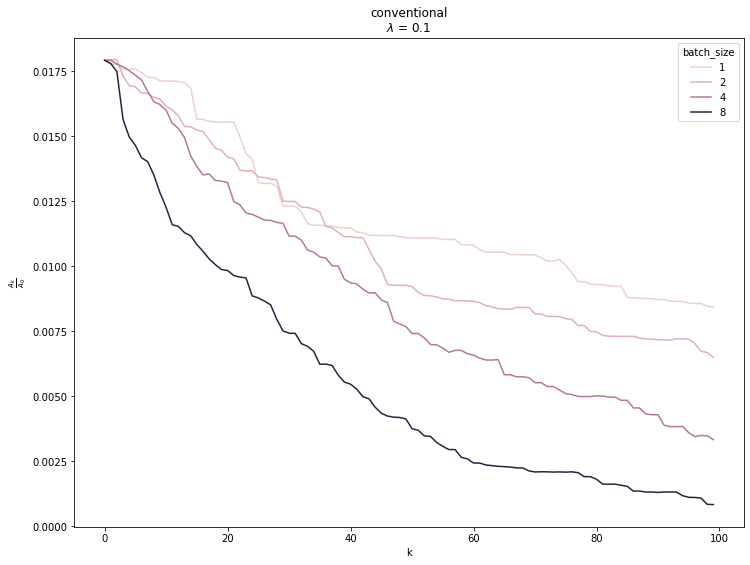

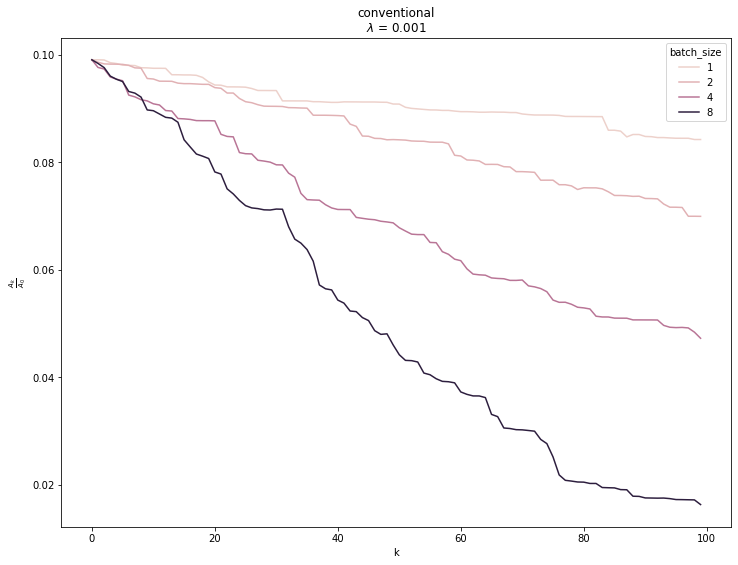

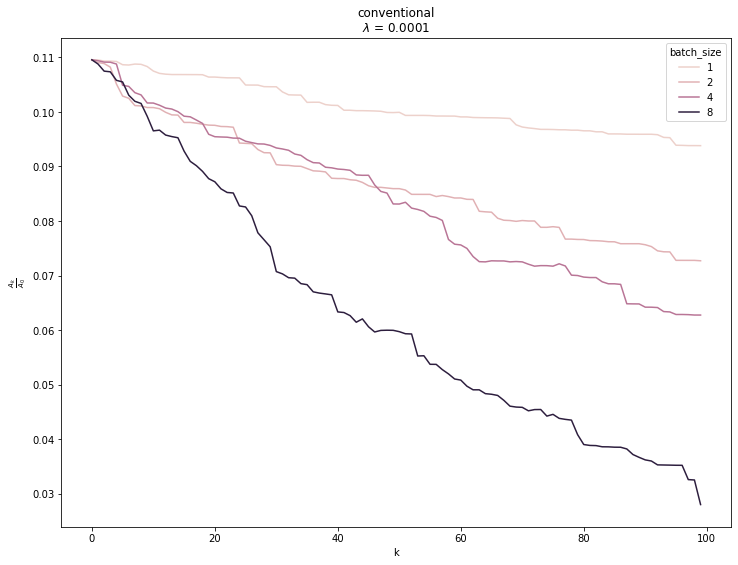

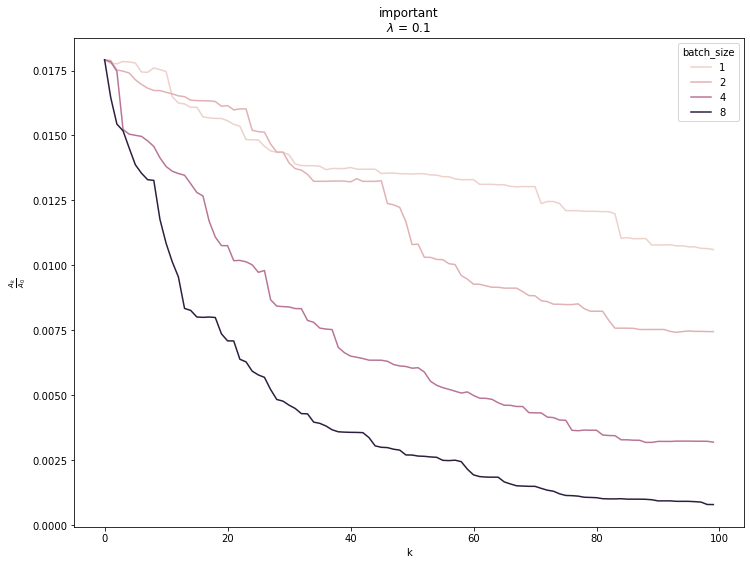

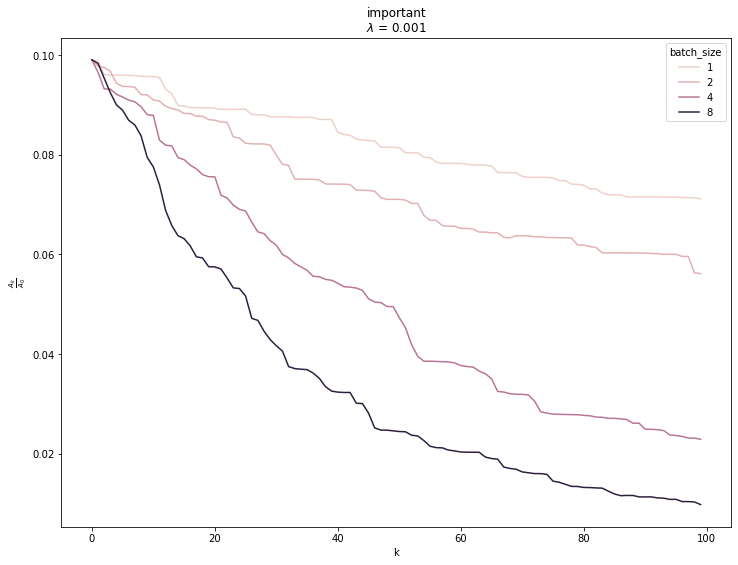

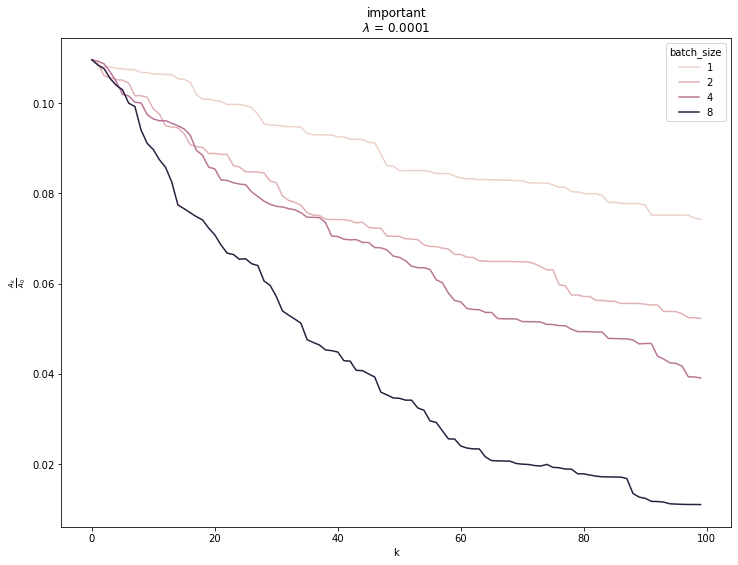

In [101]:
df = run_experiment(batch_sizes_list, lambda_list, sampling_conventional)
save_plots(df, '../data/', 'conventional', plt.savefig)
df = run_experiment(batch_sizes_list, lambda_list, sampling_important)
save_plots(df, '../data/', 'important', plt.savefig)
join_files(save_plots.saved)
clear_files(save_plots.saved)

In [102]:
pd.read_csv( '../data/saved_data2.0.csv')

,batch_size,iter,lambda,Ak/A0,sampling,version
0,1,0,0.1000,0.036059,conventional,0.0
1,1,1,0.1000,0.036059,conventional,0.0
2,1,2,0.1000,0.036055,conventional,0.0
3,1,3,0.1000,0.036038,conventional,0.0
4,1,4,0.1000,0.036035,conventional,0.0
...,...,...,...,...,...,...
3595,8,95,0.0001,0.011160,important,2.0
3596,8,96,0.0001,0.011109,important,2.0
3597,8,97,0.0001,0.011073,important,2.0
3598,8,98,0.0001,0.011070,important,2.0


In [178]:
def get_ak(df, l, s, ak):
    df2 = df[df['sampling'] == s]
    df2 = df2[df2['lambda'] == l]
    
    df2 = df2[df2['Ak/A0'] < ak]
    return df2.iloc[0].iter

1.5833333333333333 1.75 1.7777777777777777 1.7037037037037035


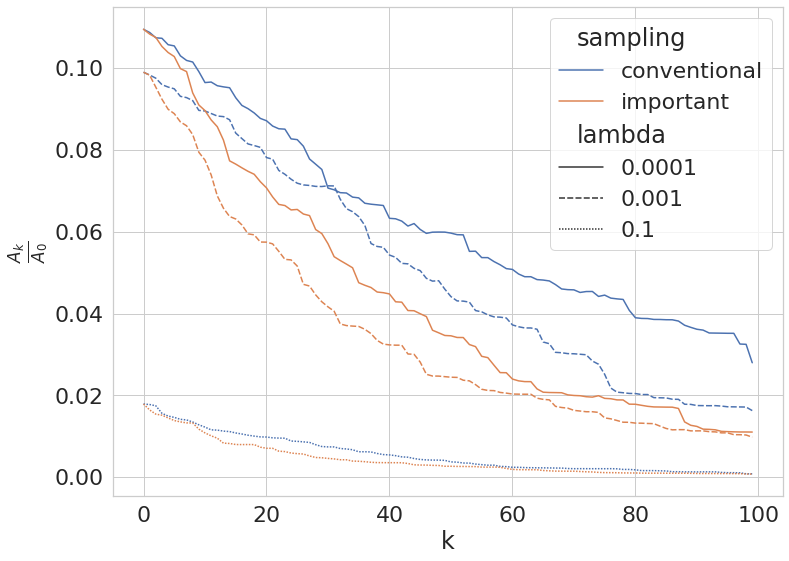

In [180]:
def DrawSingleSlide():
    colors = [('#B4B7EE', '#E79614'), ('#272EE7' ,'#BCAA02'), ('#7824CB', '#EFFF1E')]
    line_styles = ['-', '--', ':']
    
    df = get_experiment_vesion(2.0)
    del df['version']
    
    df = df[df.batch_size == 8]
    plt.figure(figsize=(12, 9))
    sns.lineplot(data=df, x='iter', y='Ak/A0', hue='sampling', style="lambda")
        
    a1 = get_ak(df, 0.1, 'conventional', 0.01)/get_ak(df, 0.1, 'important', 0.01)
    a2 = get_ak(df, 0.001, 'conventional', 0.04)/get_ak(df, 0.001, 'important', 0.04)
    a3 = get_ak(df, 0.0001, 'conventional', 0.04)/get_ak(df, 0.0001, 'important', 0.04)
    print(a1, a2, a3, (a1+a2+a3)/3)
    
#     plt.title(fr'$\lambda$ = {l}')
    plt.xlabel('k')
    plt.ylabel(r'$\frac{A_k}{A_0}$')
    
    plt.savefig('../data/single.png')
    return None

DrawSingleSlide()